In [82]:
import numpy as np
import operator
from enum import Enum
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm import tqdm
import random

In [83]:
# zmienne parametry ustawiane według potrzeb

N = 20 # liczba wszystkich agentów
N_p = int(0.2*N)  # liczba autorów, którzy opublikowali artykuł - 20% wszystkich agentów

n_sym = 5 # liczba przeprowadzonych symulacji
n_krok = 20 # liczba przeprowadzonych kroków w każdej symulacji
time_steps = 10 # liczba ostatnich kroków (po ustaleniu się układu), po których uśredniano wyniki 

v = 1  # współczynnik przypisywania jakości artykułom na podstawie zasobów
Q_sigma = 0.03  # odchylenie standardowe przy tworzeniu artykułu - badano również wartość 0
a = 0.005  # parametr skalujący zasoby po udanej publikacji
R_0 = 3  # liczba początkowa zasobów przypisywana każdemu agentowi
R_plus = 1  # liczba zasobów dodawanych po każdym kroku każdemu agentowi

In [84]:
'''
    Klasa zachowań recenzentów: rzeteleny i nieuczciwy
'''
class referee_behaviour(Enum): 
    cheater = 1
    normal = 2

In [85]:
'''
    Klasa agenta, która zawiera id, zasoby, typ zachowania jako recenzent, 
    listę opublikowanych i zrecenzowanych prac w każdej symulacji.  Posiada również dwie funkcje,
    dodające odpowiednie artykuły do list z napisanymi i zrecenzowanymi pracami.
'''
class Scientist: 
    def __init__(self, id, R, type_ref):
        self.id = id  # id agenta
        self.R = R  # zasoby agenta
        self.type_ref = type_ref  # zachowanie w roli recenzenta
        self.pubs = []  # lista napisanych prac
        self.est = []  # lista zrecenzowanych prac

    def add_pub(self,p):  # dodanie pracy napisanej
        self.pubs.append(p)

    def add_est(self,p):  # dodanie pracy zrecenzowanej
        self.est.append(p)

In [86]:
'''
    Klasa artykułu zawierająca jego autora, jego jakość, recenzenta, jakość estymowaną, 
    status (opublikowana lub nieopublikowana), krok symulacji, w którym została napisana 
    oraz zachowanie recenzenta
'''
class Publication:
    def __init__(self, auth, Q, ref, Q_est, status, i, ref_beh):
        self.auth = auth  # autor artykułu
        self.Q = Q  # jakosc artykułu
        self.ref = ref  # recenzent artykułu
        self.Q_est = Q_est  # estymowana jakosc artykułu
        self.status = status  # True - opublikowana, False - nieopublikowana
        self.i = i  # numer kroku symulacji 
        self.ref_beh = ref_beh  # zachowanie recenzenta

In [87]:
'''
    Funkcja przypisująca jakość artykułowi na podstawie zasobów autora
'''
def set_Q(author):
    Q_mean = v*author.R/(v*author.R+1)  # średnia oczekiwana jakośc artykułu
    while True:
        Q = np.random.normal(Q_mean, Q_sigma)  # jakość losowana z rozkładu normalnego o zadanym odchyleniu standardowym
        if Q<=1 and Q>=0:  # jakość ograniczona do przedziału [0,1]
            break
        else:
            continue
    return Q

In [88]:
'''
    Funkcja estymująca jakość artykułu przez recenzenta 
'''
def set_Q_est(referee,publication,publications):
    if (referee.type_ref == referee_behaviour.normal):
        Q_est = publication.Q  # recenzent rzetelny dokładnie estymuje jakość artykułu

    elif (referee.type_ref == referee_behaviour.cheater):
        x = 0.8  # współcznnik skalujący zasoby w przypadku, gdy jakość własnego artykułu jest mniejsza 
                 # od jakości artykułu recenzowanego
        '''
        Gdy jakość własnego artykułu jest mniejsza od jakości artykułu recenzowanego, 
        wówczas recenzent zaniża jakość artykułu. 
        Jeśli jednak jakość własnego artykułu jest większa od jakości artykułu recenzowanego,
        wówczas estymuja jakość dokładnie.
        '''    
        for i in publications:
            if i.auth.id == publication.ref.id:
                if i.Q < publication.Q:
                    Q_est = x*i.Q
                elif i.Q >= publication.Q:
                    Q_est = publication.Q
    return Q_est

In [89]:
'''
    Funkcja aktualizująca zasoby po każdym kroku każdemu agnetowi.
'''
def update_R(scientist, publication,u): 
    if publication.status == True:
        m = 1-scientist.R*a/(a*scientist.R+1)  # współczynnik skalujący zasoby po udanej publikacji
        scientist.R = scientist.R + scientist.R*m # aktualizacja zasobów po udanej publikacji
    else:
        scientist.R = u*scientist.R   # aktualizacja zasobów po nieudanej publikacji
    scientist.R += R_plus  # dodanie zasobow po kazdym kroku każdemu agentowi

In [90]:
'''
    Funkcja tworząca agentów przypisująca każdemu id, początkowe zasoby oraz zachowanie w roli recenzenta
    w zależności od liczby wprowadzonych nieuczciwych recenzentów.
'''
def create_scientist(n_cheaters): 
    list_of_scientists = np.zeros(N,dtype=object) 
    list_of_behaviour = [referee_behaviour.cheater if i<n_cheaters else referee_behaviour.normal if i>=n_cheaters else None for i in range(N)]
    
    for i in range(N):  
        s = Scientist(i,R_0,None)
        s.type_ref = list_of_behaviour[i]
        list_of_scientists[i] = s
    return list_of_scientists

In [91]:
'''
    Klasa symulacji z funkcjami do wyznaczania parametrów modelu.
'''
class Simulation:

    #  funkcja inicjalizująca liczbę agentów, liczbę prac, które mogą być opublikowane oraz liczbę nieuczciwych recenzentów
    def __init__(self,N,N_p,n_cheaters):
        self.N = N
        self.N_p = N_p
        self.n_cheaters = n_cheaters

        self.list_of_scientists = create_scientist(self.n_cheaters)  # stworzenie agentów

        self.evaluation_bias = np.zeros(n_krok)
        self.gini_array = np.zeros(n_krok)
        self.dif_R_array = np.zeros(n_krok)
 
    #  funkcja uruchamiana w każdym kroku
    def function(self,t,u):  # t - krok symulacji, u - parametr skalujący zasoby po nieudanej publikacji

        publications = np.zeros(N,dtype=object)
        published = np.zeros(N_p,dtype=object)
        should_be_published = np.zeros(N_p,dtype=object)

        # mieszanie agentów w celu losowego podziału na autorów i recenzentów
        # oraz przypisywanie agentowi następnego agenta z listy
        cycle_N = cycle(list(range(N)))
        next(cycle_N)
        random.shuffle(self.list_of_scientists)

        # Stworzenie artykułów, przypisanie im jakości
        for i in range(N):  
            p = Publication(self.list_of_scientists[i], set_Q(self.list_of_scientists[i]), None,None,False,t,None)
            publications[i] = p
 
        # dla każdego artykułu przypisanie recenzenta, jego zachowania, estymowanej jakości
        # oraz aktualizacja prac wszystkim agentom
        for pb in publications:
            ref = next(cycle_N)
            pb.ref = self.list_of_scientists[ref]
            pb.ref_beh = self.list_of_scientists[ref].type_ref
            pb.Q_est = set_Q_est(self.list_of_scientists[ref],pb,publications)
            self.list_of_scientists[ref-1].add_pub(pb)  # dodanie pracy do autora
            self.list_of_scientists[ref].add_est(pb)  # dodanie pracy do recenzenta
            
            
        # Sortowanie publikacji malejąco według jakości artykułu oraz według estymowanej jakości
        sorted_pub_Q_est = sorted(publications,key=operator.attrgetter('Q_est'), reverse = True) # opubliowane
        sorted_pub_Q = sorted(publications,key=operator.attrgetter('Q'), reverse = True) # powinny byc opublikowane
        
        
        # Lista opublikowanych i nieopublikowanych artykułów
        for i in range(N_p):
            sorted_pub_Q_est[i].status = True  # ustawienie statusu pracy jako opublikowana
            published[i] = sorted_pub_Q_est[i]  # prace opublikowane
            should_be_published[i] = sorted_pub_Q[i]  # prace, które powinny być opublikowane
        
        # wyznaczenie stronniczosci oceny - evaluation bias
        EB = len(set(published) - set(should_be_published))  
        self.evaluation_bias[t-1] = EB/len(published)*100

        #  aktualizacja zasobów
        for x,y in zip(self.list_of_scientists, publications):
            update_R(x,y,u)  
        
        # wyznaczenie wskaźnika Giniego oraz różnicy między zasobami agenta a średnią zasobów         
        self.Gini_and_diff_resources(t-1,publications,self.gini_array,self.dif_R_array)

     
    #  funkcja wyznaczająca wskaźnik Giniego oraz różnicę między zasobami agenta a średnią zasobów        
    def Gini_and_diff_resources(self,t,publications,gini_array,dif_R_array):   
        diff = 0
        dif = 0
        resources = 0
        for i in publications:
            resources += i.auth.R
            for j in publications:
                diff += np.abs(i.auth.R-j.auth.R)  
        mean_R = resources/len(publications)  # wyznaczenie średniej zasobów
        gini = diff/(2*mean_R*len(publications)**2)  # wzór na wskaźnik Giniego
        gini_array[t] = gini
        
        for k in publications:
            dif += np.abs(k.auth.R-mean_R)
        dif_mean_R = dif/mean_R/len(publications)  # wzór na różnicę zasobów
        dif_R_array[t]=dif_mean_R
        
    # funkcja wyznaczająca liczbę autorów, który nieopublikowali żadnego artykułu    
    def unpub_authors(self):
        number_of_unpub_authors = 0
        for i in self.list_of_scientists:
            l=0
            statuses = np.zeros(time_steps)
            for j in i.pubs[-time_steps:]:
                statuses[l] = j.status
                l+=1
            if any(statuses) == False:
                number_of_unpub_authors +=1
        return number_of_unpub_authors

        
    #  wyznaczanie średnich wartości parametrów po jednej symulacji
    def mean_params_in_step(self,n,percentage_unpublicated_authors_array,evaluation_bias_array,gini_array,dif_R_array):

        EB_mean = np.mean(self.evaluation_bias[-time_steps:])  
        evaluation_bias_array[n]=EB_mean 
        
        number_of_unpub_authors = self.unpub_authors()
        percent_unpublished_authors = number_of_unpub_authors/N*100
        percentage_unpublicated_authors_array[n]=percent_unpublished_authors
        
        gini_mean = np.mean(self.gini_array[-time_steps:])
        gini_array[n]=gini_mean
        
        dif_R_mean = np.mean(self.dif_R_array[-time_steps:])
        dif_R_array[n]=dif_R_mean
    
    # funkcja wyznaczająca zasoby agentów w jednym kroku    
    def resources(self,n,resources):
        if n==0:
            for i in self.list_of_scientists:
                resources[np.where(self.list_of_scientists==i)] = i.R

In [92]:
     
# funkcja uśredniająca wartości parametrów po wszyskich symulacjach
def mean_many_simulations(unpub_auth,bias, gini,dif_R):
    return np.mean(unpub_auth), np.mean(bias), np.mean(gini), np.mean(dif_R)

In [93]:
cheaters = np.arange(0,100,5)

# funkcja przeprowadzająca symulację
def run_simulation(i,u):
    
    bias = np.zeros(n_sym)
    gini = np.zeros(n_sym)
    unpub_auth = np.zeros(n_sym)
    dif_R = np.zeros(n_sym)
        
    for ss in range(n_sym):
        s = Simulation(N,N_p,i)        

        for j in range(n_krok): 
            s.function(j+1,u) 
        s.mean_params_in_step(ss,unpub_auth,bias,gini, dif_R)
        
    unpub_auth_m,bias_m, gini_m, dif_R_m = mean_many_simulations(unpub_auth,bias,gini,dif_R)

    globals()[f"array_ev_bias{u}"][np.where(cheaters==i)] = bias_m
    globals()[f"array_gini{u}"][np.where(cheaters==i)] =  gini_m
    globals()[f"array_unpub_auth{u}"][np.where(cheaters==i)] = unpub_auth_m
    globals()[f"array_diff_R{u}"][np.where(cheaters==i)] = dif_R_m

    

In [94]:

U = [0, 0.25,0.5, 0.75, 0.9, 1]  # wartości parametru skalującego zasoby po nieudanej publikacji

for u in U:
    globals()[f"array_ev_bias{u}"] = np.zeros(len(cheaters))
    globals()[f"array_gini{u}"] = np.zeros(len(cheaters))
    globals()[f"array_unpub_auth{u}"] = np.zeros(len(cheaters))
    globals()[f"array_diff_R{u}"] = np.zeros(len(cheaters))
    
# uruchomienie symulacji dla różnej liczby zachowań nieuczciwych oraz różnych wartości parametru u
for u in U:
   for i in tqdm(cheaters):
       run_simulation(i,u)

100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


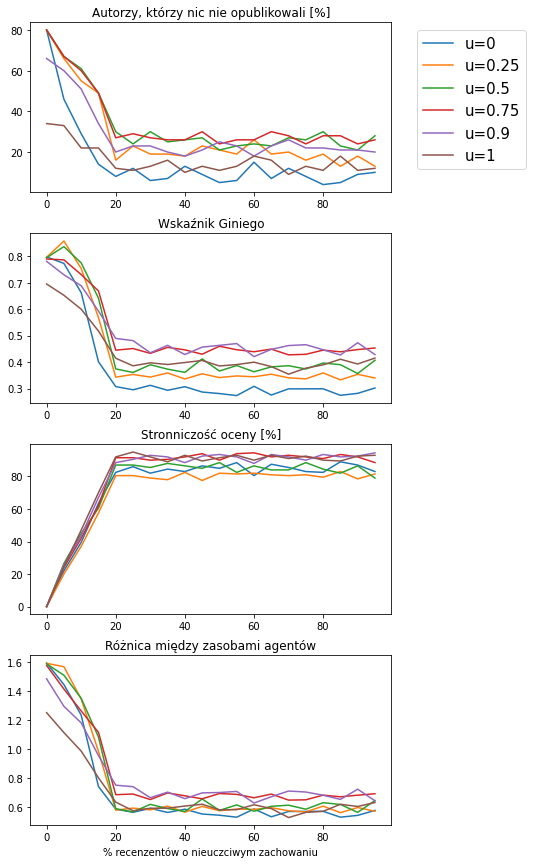

In [95]:
'''
    Wykreślenie parametrów wyznaczonych podczas symulacji w zależności od liczby nieuczciwych recenzentów
    dla różnych wartości parametru skalującego zasoby po nieudanej publikacji. 
'''
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,sharex=False,figsize=(6,12))
fig.tight_layout(pad=2.0)
for u in U:
    ax1.plot(cheaters,globals()[f"array_unpub_auth{u}"],label = f'u={u}')    
    ax2.plot(cheaters,globals()[f"array_gini{u}"])
    ax3.plot(cheaters,globals()[f"array_ev_bias{u}"])
    ax4.plot(cheaters,globals()[f"array_diff_R{u}"])
    
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',prop={'size': 15})
ax1.set_title('Autorzy, którzy nic nie opublikowali [%]')
ax2.set_title('Wskaźnik Giniego')
ax3.set_title('Stronniczość oceny [%]')
ax4.set_title('Różnica między zasobami agentów')
ax4.set_xlabel("% recenzentów o nieuczciwym zachowaniu")

plt.savefig("params-cheaters-0.pdf",bbox_inches='tight')
plt.show()

In [98]:
#  funkcja przeprowadzająca symulację w celu uzyskania histogramów zasobó agentów
def run_simulation_hist(i,u):
        
    for ss in range(n_sym):
        s = Simulation(N,N_p,i)        

        for j in range(n_krok): 
            s.function(j+1,u) 
        s.resources(ss,globals()[f"resources{u}"])

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


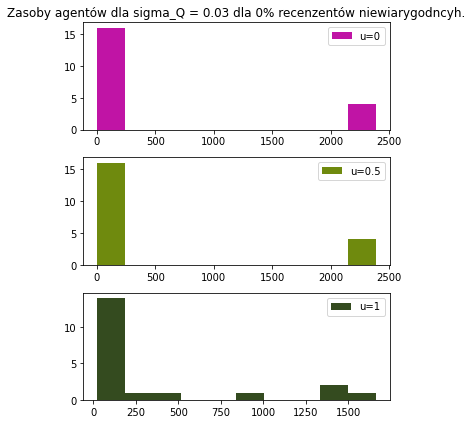

100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


<Figure size 432x288 with 0 Axes>

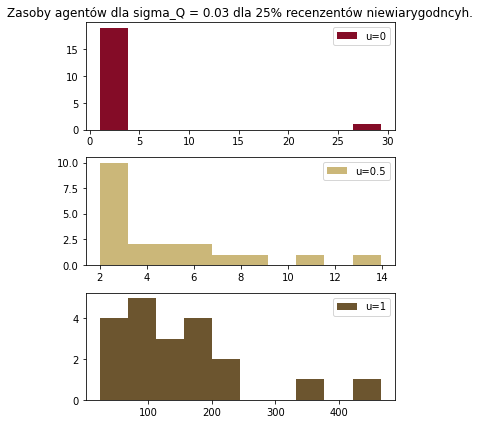

100%|██████████| 3/3 [00:00<00:00,  5.75it/s]


<Figure size 432x288 with 0 Axes>

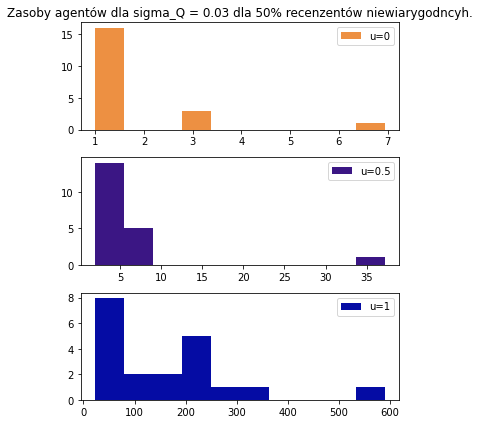

100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


<Figure size 432x288 with 0 Axes>

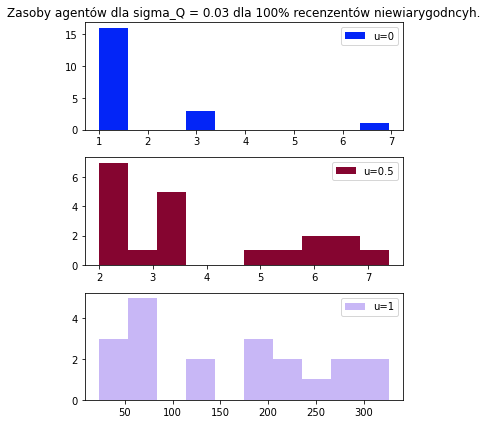

<Figure size 432x288 with 0 Axes>

In [99]:
'''
    Wyznaczenie oraz wykreślenie zasobów agnetów po jednej symulacji dla różnej 
    liczby recenzentów nieuczciwych dla różnych wartości parametru u
'''
number_of_cheaters = [0,25,50,100]   
U = [0,0.5, 1]
   
for i in number_of_cheaters:
    fig, axs = plt.subplots(3,1,tight_layout=True,figsize=(5,6),sharex=False)
    fig.tight_layout(pad=2.0)

    for u in U:
         globals()[f"resources{u}"] = np.zeros(N)
    
    for u in tqdm(U):
        r = np.random.random_sample()
        b = np.random.random_sample()
        g = np.random.random_sample()
        color = (r, g, b)
        run_simulation_hist(i,u)
        axs[U.index(u)].hist(globals()[f"resources{u}"],label= f'u={u}',color=color)
        axs[U.index(u)].legend()
        
    axs[0].set_title(f"Zasoby agentów dla sigma_Q = {Q_sigma} dla {i}% recenzentów niewiarygodncyh.")
    plt.savefig(f"cheaters-0-{i}.pdf",bbox_inches='tight')
    plt.show()
    plt.clf()
        
        